# Explore the data in a GRDC day file

In [1]:
# set everything up
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grdc_explore import dataframe_from_stationId, valid_series, fill_with_empty_rows, replace_nans

pd.set_option('display.width', 1000)  # give print extra width to print more columns

### Read in station data from a folder containing the GRDC files, using the station identifier.

Specify the folder containing the GRDC daily datafiles and the station IDs of interest

In [2]:
my_grdc_folder = ".\GRDCdat_day"
# Use the line above if you started this notebook in a folder that contains the subfolder 'GRDCdat_day'
# my_grdc_folder = "D:\sbranchett\Jerom\GRDCdat_day"
my_stations = [5202120, 6196700, 1445500, 5202150]

In [3]:
# collect the GRDC data for the specified stations
grdc_dataframes = {}
for station in my_stations:
    grdc_dataframes[station] = dataframe_from_stationId(my_grdc_folder, station)

### Missing data is set to -999, so these are easily visible as large negative values of discharge.

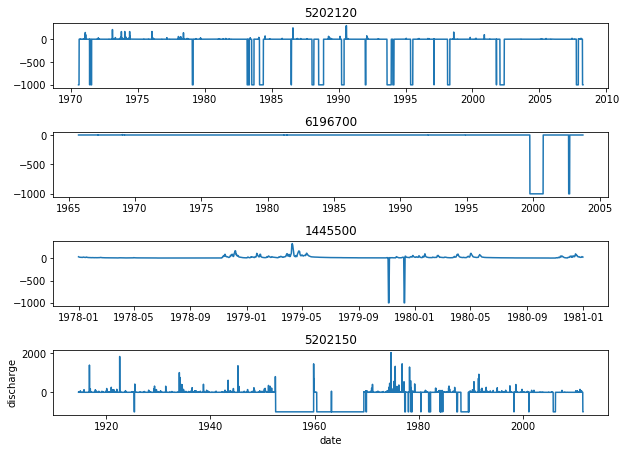

In [4]:
# plot the discharge values as a function of the date for the specified stations

no_plots = len(grdc_dataframes)
fig, axs = plt.subplots(no_plots, 1, figsize=(8.8, 1.6*no_plots))

if no_plots == 1:
    for idx, grdc_dataframe in grdc_dataframes.items():  # there is only one station to plot
        plt.plot(grdc_dataframe.drop(columns=['date']))
elif no_plots > 1:
    subplot_index = 0
    for idx, grdc_dataframe in grdc_dataframes.items():
        axs[subplot_index].plot(grdc_dataframe.drop(columns=['date']))
        axs[subplot_index].set_title(idx)
        subplot_index += 1

plt.xlabel('date')
plt.ylabel('discharge')
plt.tight_layout()

### Make a dataframe containing valid discharge values for all the stations of interest

In [5]:
init = True
for idx, grdc_dataframe in grdc_dataframes.items():
    if init:  # for the first station, there is no other data to merge with
        combined = grdc_dataframe.drop(columns=['date']).rename(columns={'discharge': 'discharge_'+str(idx)})
        init = False
    else:
        combined = pd.merge(combined, grdc_dataframe.drop(columns=['date']), how='outer', on='date',
                            sort=True)
        combined = combined.rename(columns={'discharge': 'discharge_'+str(idx)})

combined = combined.replace(-999., np.nan)  # redefine the -999 discharge values as missing data

# run these lines to test missing rows
combined = combined.drop(pd.Timestamp('1979-11-07'))

combined['1979-11-03':'1979-11-09']

In [6]:
cleaned = combined.dropna(axis=0, how='any')
# 'combined' now contains the data for all the specified stations, including NaNs where there is no valid data
# 'cleaned' has rows/days which have valid discharge data for all specified station

### Make series with valid data and (nearly) consecutive dates

How many days may have data problems?

Specify the number of consecutive days in a series that may have invalid data.

Each station is evulated separately.

Default is 0.

In [7]:
num_invalid_days = 4

In [8]:
series = valid_series(cleaned, num_invalid_days)
print(series)

  Start Date   End Date Number of days in series
0 1978-01-12 1978-06-18                      158
1 1978-07-06 1978-08-28                       54
2 1978-09-14 1979-01-27                      136
3 1979-02-20 1980-05-13                      449
4 1980-05-30 1980-12-31                      216


### Select the index of the series above that you wish to study further

In [9]:
series_idx = 3

In [10]:
start_date = series.loc[series_idx, "Start Date"]
end_date = series.loc[series_idx, "End Date"]

series_combined = combined.loc[start_date:end_date]  # contains data for all the specified stations,
# for the time series selected. Includes NaN where there is no valid data

### Check that the dataframe for the selected series has consecutive days, one day for each row

In [11]:
# Check that days are consecutive by first trying to add missing days
series_combined = fill_with_empty_rows(series_combined, series_combined.index[0],
                                       series_combined.index[-1])

if ((series_combined.index[-1] - series_combined.index[0]).days + 1 != len(series_combined.index)):
    print('The number of rows is not the same as the number of days. \
    Check that the Dataframe has one row per day and that the rows are sorted on date')

### Inspect any problem rows

In [12]:
# There should be no problems if num_invalid_days is 0
problems = series_combined[pd.isna(series_combined).any(axis=1)]
print(problems)
print(len(problems))

            discharge_5202120  discharge_6196700  discharge_1445500  discharge_5202150
date                                                                                  
1979-11-05              0.456                0.0                NaN              1.404
1979-11-06              0.379                0.0                NaN              1.579
1979-12-09              0.194                0.0                NaN              0.761
1979-12-10              0.111                0.0                NaN              0.744
4


### Do you want to replace the problem data with values calculated by linear interpolation of closest valid data?

In [13]:
interpolate = True  # if num_invalid_days is 0 and len(problems) is zero, interpolate = True will have no effect

In [14]:
if interpolate:
    interpolated = replace_nans(series_combined)

# run these lines to test missing rows

print(series_combined['1979-11-03':'1979-11-09'])

if interpolate:
    print(interpolated['1979-11-03':'1979-11-09'])

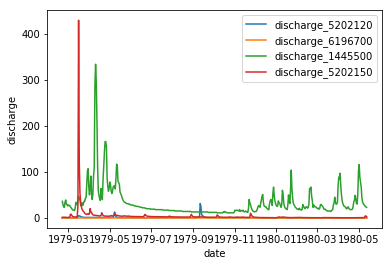

In [15]:
# plot the cleaned up series

if (interpolate):
    series_to_plot = interpolated
else:
    series_to_plot = series_combined

plt.plot(series_to_plot)

plt.xlabel('date')
plt.ylabel('discharge')
plt.legend(series_to_plot.columns, loc='upper right')